In [1]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(2017)  # for reproducibility

%matplotlib inline

# Προσομοιωμένη Ανόπτηση

Στην άσκηση αυτή θα χρησιμοποιήσετε τη μέθοδο της προσομοιωμένης ανόπτησης
([simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing)) για
να βρείτε το ελάχιστο μιας συνάρτησης $V: \mathbb{R} \to \mathbb{R}$. 
Σαν παράδειγμα ξεκινάμε με την πολυωνυμική συνάρτηση:

$$ V(x) = \frac{x^4}{4} + \frac{7 x^3}{15} + \frac{4 x^2}{5} + \frac{4x}{5} + 2.$$

Η γραφική της παράσταση κατασκευάζεται στο παρακάτω κελί.


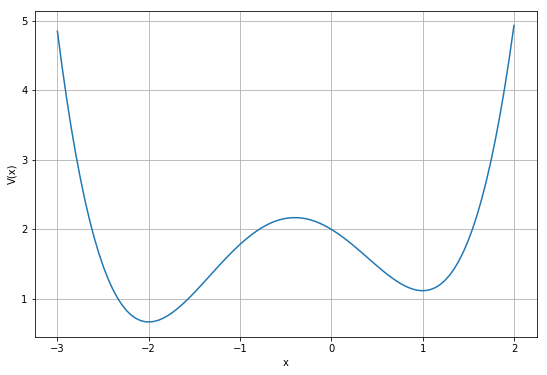

In [2]:
def V(x):
    """Energy (objective) function to minimize"""
    return np.polyval((0.25, 7/15, -0.8, -0.8, 2.0), x)

x = np.linspace(-3, 2, 100)

plt.figure(figsize = (9, 6))
plt.plot(x, V(x))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.grid(True)
plt.show()

Όπως παρατηρείτε η συνάρτηση έχει ένα ολικό ελάχιστο στο $x= -2$ και ένα τοπικό ελάχιστο
στο $x = 1$.

Ο αλγόριθμος της προσομοιωμένης ανόπτησης δουλεύει ως εξής. Αρχικά ένα "σωματίδιο" είναι
τοποθετημένο τυχαία στο διάστημα $(-3.5, +3.5)$ και έχει θερμοκρασία $T = 128$. 
Σε κάθε επανάληψη επιχειρεί μια μετατόπιση που ακολουθεί ομοιόμορφη κατανομή στο διάστημα 
$(−\delta, +\delta)$ και πραγματοποιεί τη μετατόπιση σύμφωνα με τον αλγόριθμο *Metropolis-Hastings*.
Όπως και στο προηγούμενο εργαστήριο, η θερμοκρασία ελέγχει πόσο "ευέλικτο" είναι το σωματίδιο μας,
δηλαδή πόσο εύκολα αποδέχεται μετακινήσεις $x\to y$ που φαίνονται χειρότερες ($V(y)>V(x)$) από την
παρούσα θέση. 

Αρχικά αφήνουμε το σωματίδιο να κινείται ελεύθερα και να εξερευνεί το χώρο (μεγάλη θερμοκρασία)
αλλά στη συνέχεια, κάθε $n$ βήματα, το περιορίζουμε (ρίχνουμε τη θερμοκρασία). 
Η ιδέα είναι ότι αφού δώσουμε στο σωματίδιο την ευκαιρία να εξερευνήσει το χώρο για κάποιο διάστημα, καθώς το ψύχουμε
αυτό θα προτιμάει να επισκέπτεται κοιλάδες παρά λόφους. Σκοπός μας είναι σιγά σιγά να παγιδεύσουμε
το σωματίδιο στην βαθύτερη κοιλάδα (κοντά στο ελάχιστο της συνάρτησης $V$.) Η διαδικασία αυτή (της σταδιακής ψύξης) συνεχίζεται μέχρι η θερμοκρασία να φτάσει στην $T_{min}$

*Σημείωση*: Η συνάρτηση `np.polyval(p, x)` παίρνει σαν είσοδο ένα διάνυμα `p` και ένα μία τιμή `x`
και υπολογίζει το πολυώνυμο $ p \cdot {(x^d, x^{d-1}, ..., x^0)}^T$ όπου `d` είναι η τάξη του `p`. Όταν το `x`
είναι διάνυσμα (όπως στην περίπτωση μας), υπολογίζει την τιμή πολυωνύμου στο σημείο `x`.

## Αλγόριθμος

Στο επόμενο κελί κώδικα σας δίνουμε μια απλή υλοποίηση της ιδέας αυτής.

In [3]:
def sim_anneal(f, x_low, x_high,
               T=2.0, T_min=2**(-12), 
               cool_factor=0.9, cool_sch=100,
               delta = 1.0, shrink_factor=0.5, shrink_thres=0.25,
               trace = False):
    
    # Initialize
    x = np.random.uniform(x_low, x_high)
    f_cur = f(x)  # current value of f
    steps = accepted = 0
    if trace: path = []

    # Main loop
    while T > T_min:
        
        # proposed new position
        x_new = x + np.random.uniform(-delta, delta)
        if x_new > x_high or x_new < x_low:
            continue  # skip this proposal
        f_new = f(x_new)

        # accept/reject jump
        if np.log(np.random.rand()) < -(f_new - f_cur) / T :
            x, f_cur = x_new, f_new
            accepted += 1            
                
        # Cooling
        if steps == cool_sch:  # time for the next cooling
            T *= cool_factor  # cool down
            # Adjust Search Space
            if accepted / steps < shrink_thres:
                delta *= shrink_factor
            steps = accepted = 0
        
        if trace: path.append(x)
        steps += 1        
        
    
    if trace: return path
    return x

Οι παράμετροι της συνάρτησης `sim_anneal` είναι:

* **`f`**: η συνάρτηση που θέλουμε να ελαχιστοποιήσουμε
* **`x_low, x_high`**: Το όρια μέσα στα οποία ψάχνουμε να βρούμε το ελάχιστο
* **`T, T_min`**: Η αρχική και η τελική θερμοκρασία της "ανόπτησης"
* **`cool_factor`**: Πόσο μειώνεται η θερμοκρασία σε κάθε κύκλο ψύξης (ποσοστό της προηγούμενης)
* **`cool_sch`**: Κάθε πόσα βήματα να μειώνεται η θερμοκρασία
* **`delta`**: Ακτίνα από την οποία θα προτείνουμε άλμα
* **`shrink_factor`**: Πόσο θα μειώσουμε το `delta` αν δούμε ότι η μέθοδος έχει κολλήσει
* **`shirnk_thres`**: Ποσοστό το επιτυχημένων αλμάτων κάτω από το οποίο θεωρούμε ότι το σωματίδιο έχει κολλήσει.
* **`trace`**: Αν θέλουμε να μας γυρίσει όλη την διαδρομή ή μόνο την τελική θέση

Επομένως για να βρούμε το ελάχιστο της συνάρτησης $V$ που ορίσαμε προηγουμένως στο
διάστημα $(-3.5, 3.5)$ τρέχουμε την συνάρτηση με τις εξής παραμέτρους.

*Παρατήρηση: Ζητάμε όλο το μονοπάτι του σωματιδίου για να το πλοτάρουμε αργότερα.*

In [4]:
# Parameters
T_start, T_end = 2.0, 2**(-12)
cool_sch, cool_factor = 100, 0.99

path = sim_anneal(V, -3.5, 3.5, delta = 1.,
                  T = T_start, T_min = T_end,
                  cool_factor = cool_factor, 
                  cool_sch = cool_sch,
                  trace = True)  # keep the default for the rest

path[-1]  # last position

0.9911873133787367

Το επόμενο κελί κώδικα οπτικοποιεί τη διαδικασία.

In [5]:
%matplotlib qt
%run animate_simanneal.py -minima 0

ImportError: Matplotlib qt-based backends require an external PyQt4, PyQt5,
PySide or PySide2 package to be installed, but it was not found.

Το πρόγραμμα `animate_simanneal.py` μπορεί να δεχτεί για ορίσματα:

- **`minima`**  επιλέγει ένα πολυώνυμο με {0,1,2,3} ακρότατα. 
Για μηδέν είναι το παράδειγμα που δόθηκε
- **`T0`** Αρχική θερμοκρασία (default 128)Initial Temperature
- **`T1`** Τελική θερμοκρασία (default 0.01)
- **`CF`** Ποσοστό απώλειας θερμοκρασία σε κάθε βήμα (default 0.5)
- **`CS`** Περίοδος ψύξης (default 100)
- **`d`** ακτίνα που άλματος (default 3.0)
- **`--delay`** χρόνος μεταξύ frames σε ms (default 100)

Δοκιμάστε να δώσετε άλλα δεδομένα και δείτε πως αλλάζει η συμπεριφορά της ανόπτησης.

Αν η εντολή σας βγάλει σφάλμα στο notebook δοκιμάστε να την τρέξετε
από το terminal ως

`python animate_simanneal.py -minima 0`

Τρέξτε το παρακάτω κελί ώστε τα διαγράμματα να εμφανίζονται μέσα στο notebook.

In [8]:
%matplotlib inline

## Παραδοτέο

Σε ένα καινούργιο jupyter notebook, χρησιμοποιήστε την μέθοδο της προσομοιωμένης ανόπτησης για την συνάρτηση:

$$ V(x) = \frac{13}{90} x^4 - \frac{3}{10} x^3 - \frac{101}{45} x^2 \frac{13}{15}x + 4$$

Α) Τρέξτε τον αλγόριθμο `200` φορές και υπολογίστε το ποσοστό των πειραμάτων στα οποία 
ο αλγόριθμος βρήκε το ολικό ελάχιστο και το ποσοστό στο οποίο βρήκε κάποιο τοπικό ελάχιστο
(με ακρίβεια 0.05)

Β) Τρέχτε τον αλγόριθμο `200` φορές για τιμές του `cool_factor = [0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]` και εκτιμήστε για κάθε τιμή του την πιθανότητα ο αλγόριθμος να υπολογίσει το ολικό ελάχιστο. 
Κάντε διάγραμμα των τιμών του `cool_factor` και της πιθανότητας εύρεση του ολικού ελάχιστου.

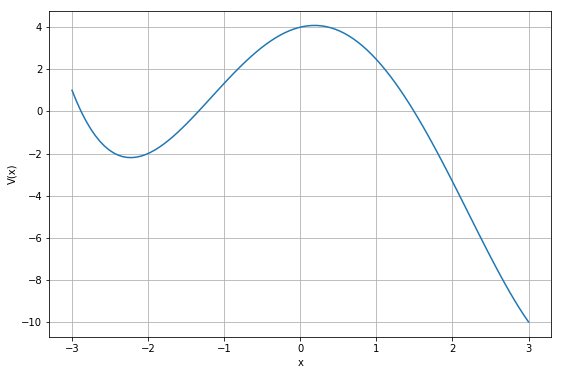

3.4999915464796425
-2.225986411877194
-2.226788618073408
-2.2219819111825423
3.4999632532083735
3.4999735556520224
3.499702316744052
3.499818987192923
3.499801162131019
3.499671217872351
-2.22011988450709
3.4993047039298424
-2.233462284391492
-2.219950476862765
-2.2208328326076123
3.499898619459238
3.499815613223352
3.499757829311803
-2.2366012129940382
-2.2287791452275716
-2.2354157779030195
3.4996601700463392
-2.236593080383981
3.499888840125621
3.4997412508538224
3.4996101915195585
3.4996368657727484
3.499729068040354
-2.239505279989289
3.499969812998356
3.499748871109661
3.4998496329892372
3.4999642612593638
-2.2219159713073084
3.499828118926446
-2.231228022899185
-2.237046798509083
3.499875068092422
3.4995453521625333
-2.2390339408504287
3.4999699902179384
-2.2334786535736253
3.499916737949943
3.4998540205405617
-2.2295431426029944
3.4994990268848736
-2.235704638497246
3.499944222935978
-2.2222929004096494
3.499719589248835
3.499993004473997
-2.225236193008646
3.4999947488913117
-

In [5]:
def U(x):
    """Energy (objective) function to minimize"""
    return np.polyval((13/90, -0.3, -101/45, 13 / 15 , 4), x)

x = np.linspace(-3, 3, 100)

plt.figure(figsize = (9, 6))
plt.plot(x, U(x))
plt.xlabel("x")
plt.ylabel("V(x)")
plt.grid(True)
plt.show()

# Parameters
T_start, T_end = 1, 2**(-12)
cool_sch, cool_factor = 100, 0.99
paths = []

for i in range(200):
    path = sim_anneal(U, -3.5, 3.5, delta = 1.,
                      T = T_start, T_min = T_end,
                      cool_factor = cool_factor, 
                      cool_sch = cool_sch,
                      trace = True)  # keep the default for the rest
    paths.append(path)
    print(path[-1])


##  Πλανόδιος Πωλητής

Στην άσκηση αυτή θα χρησιμοποιήσουμε τον αλγόριθμο της προσομοιωμένης ανόπτησης
για να λύσουμε το πρόβλημα του [πλανόδιου πωλητή](https://en.wikipedia.org/wiki/Travelling_salesman_problem).

Το πρόβλημα έχει ως εξής:

> Ένας πωλητής θέλει να επισκεφτεί $Ν$ πόλεις και να γυρίσει στη βάση του.
Ποια είναι η συντομότερη διαδρομή που ενώνει όλες τις πόλεις;

Στη συγκεκριμένη άσκηση θα ασχοληθούμε με πόλεις της Ευρώπης.
Τρέξτε το παρακάτω κελί κώδικα. Θα πρέπει να σας κατεβάσει το αρχείο [eu.csv](http://math.ntua.gr/~loulakis/info/python_codes_files/eu.csv) που περιέχει 
το γεωργαφικό μήκος και πλάτος 27 ευρωπαϊκών πόλεων. Ο κώδικας οργανώνει την πληροφορία ως εξής:

* **`city_coord`** ένα `dictionary` που για κάθε πόλη έχει το γεωγραφικό μήκος και πλάτος
* **`Ncities`** ο αριθμός των πόλεων (27)
* **`city_names`** τα ονόματα των πόλεων

Το κελί τυπώνει τις συντεταγμένες της Αθήνας για επαλήθευση.

In [10]:
import csv
import urllib.request

url = "http://math.ntua.gr/~loulakis/info/python_codes_files/eu.csv"
with urllib.request.urlopen(url) as urlstream:
    csvfile = csv.reader(urlstream.read().decode('utf-8').splitlines(), delimiter=",")
    city_coord = {city: tuple(map(float, (longitude, latitude))) 
                  for longitude, latitude, city, _ in csvfile}

Ncities = len(city_coord)  # number of cities
city_names = list(city_coord.keys())
city_coord["Athens"]

(37.97918, 23.716647)

Στο επόμενο κελί ορίζουμε την συνάρτηση `geodesic_dist` η οποία υπολογίζει την
απόσταση μεταξύ 2 πόλεων δοθέντων των συντεταγμένων τους (credit to [Michael Dunn](http://stackoverflow.com/a/4913653/2167530)) με βάση τον τύπο [Haversine](https://en.wikipedia.org/wiki/Haversine_formula)

In [11]:
def geodesic_dist(city1, city2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    if city1 == city2:
        return 0.
    lon1, lat1 = np.deg2rad(city1)
    lon2, lat2 = np.deg2rad(city2)
    
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers 6371. Use 3956 for miles
    return c * r

Για ευκολία και ταχύτητα θα υπολογίσουμε όλες της αποστάσεις εκ των προτέρων και θα τις αποθηκεύσουμε σε ένα πίνακα

In [12]:
# Distance between every pair of cities
dist = np.array([
    [geodesic_dist(coord1, coord2) for coord2 in city_coord.values()]
    for coord1 in city_coord.values()
])

Σαν σύμβαση θεωρούμε ότι η αρχική σειρά των πόλεων είναι αυτή με την οποία
μπορούμε να κάνουμε iterate το `city_coord` δηλαδή:

In [13]:
for i, city in enumerate(city_coord): print(i, city)

0 London
1 Nicosia
2 Edinburgh
3 Oslo
4 Lisbon
5 Madrid
6 Vienna
7 Brussels
8 Paris
9 Sofia
10 Belgrade
11 Luxembourg
12 Bucharest
13 Riga
14 Stockholm
15 Helsinki
16 Budapest
17 Amsterdam
18 Athens
19 Berlin
20 Reykjavik
21 Rome
22 Moscow
23 Monaco
24 Copenhagen
25 Prague
26 Warsaw


## Αλγόριθμος

Επειδή ο δρόμος που θα ακολουθήσει ο πωλητής είναι κυκλικός, δεν έχει σημασία
από που θα ξεκινήσει (μόνο ποιες πόλεις θέλει να επισκεφθεί έχει σημασία).
Ως εκ τούτου, "λύση" στο πρόβλημα μας είναι μια λίστα με τη σειρά με την οποία
κάποιος πρέπει να επισκεφθεί τις πόλεις, δεδομένου ότι μετά την τελευταία πόλη
θα επιστρέψει στην αρχική χωρίς να επισκεφθεί άλλη πόλη.

Επομένως, σκοπός μας είναι να χρησιμοποιήσουμε την τεχνική της προσομοιωμένης ανόπτησης για να
"ψάξουμε" τον χώρο των μεταθέσεων της λίστας των πόλεων ώστε να
βρούμε την μετάθεση που δίνει την συνολική απόσταση κοντά στην ελάχιστη δυνατή.

Για να τρέξουμε τον αλγόριθμο της ανόπτησης χρειαζόμαστε 2 στοιχεία:

1. Μια συνάρτηση *ενέργειας*
2. Έναν τρόπο να μεταβαίνουμε σε γειτονικές καταστάσεις

Ως συνάρτηση ενέργειας θα πάρουμε την συνολική απόσταση που διανύει ο πωλητής 
(αυτή που θέλουμε να ελαχιστοποιήσουμε). 
Στο παρακάτω κελί ορίζουμε την συνάρτηση (είσοδος η σειρά με την οποία ο πωλητής επισκέπτεται τις πόλεις):

In [14]:
def total_dist(cities):
    """The total distance covered by the salesman"""
    total = sum(dist[city1][city2] for city1, city2 in zip(cities[:-1], cities[1:]))
    total += dist[cities[-1]][cities[0]] # return to start
    return total

Ως γειτονικές μεταθέσεις, ορίζουμε τις μεταθέσεις που διαφέρουν μόνο σε ένα ζευγάρι πόλεων. 
Επομένως για να κινηθούμε στον χώρο το μεταθέσεων, θα διαλέγουμε τυχαία 2 πόλεις και θα αλλάζουμε
τη θέση τους στη λίστα.

Για να υπολογίσουμε την αλλαγή στην συνολική απόσταση για μια τέτοια αλλαγή,
μπορούμε να προσθέσουμε όλες τις αποστασεις από την αρχή αλλά προφανώς κάτι τέτοιο 
δεν είναι αποδοτικό. Γι' αυτό το λόγο ορίζουμε την συνάρτηση `dist_diff`.
Στην επόμενη ενότητα εξηγούμε την λογική της συνάρτησης, αν δεν την καταλαβαίνετε
μπορείτε απλά να την χρησιμοποιήσετε σαν μαύρο κουτί.

### Κόστος αλλαγής σειράς επίσκεψης

Η αλλαγή της σειράς 2 πόλεων είναι μια τοπική αλλαγή επομένως αρκεί να σκεφτούμε ποιές είναι
συνέπειες αυτές της αλλαγής. *Πόσες αποστάσεις επηρεάζονται συνολικά;*

Θεωρείστε 2 τριάδες πόλεων τυχαία μέσα στη λίστα:

* $A \to B \to C$ και 
* $X \to Y \to Z$

και και χωρίς βλάβη στη γενικότητα θεωρείστε ότι η πόλη $B$ εμφανίζεται
πριν από την $Y$ στη λίστα.

Υπάρχουν 2 περιπτώσεις

1. Γενική περίπτωση $B$ και $Y$ δεν συνορεύουν (δηλαδή $X \not\equiv B$)
2. Ειδική περιπτωση $B$ και $Y$ συνορεύουν (δηλαδή $X \equiv B$)

Στο παρακάτω διάγραμμα φαίνονται οι συνέπειες που θα είχε μια αλλαγή μεταξύ $B$ και $Y$
στις 2 αυτές περιπτώσεις


![TSP Swap Cases](http://math.ntua.gr/~loulakis/info/python_codes_files/tsp_swap.svg)

Στο παρακάτω κελί ορίζουμε την συνάρτηση.

In [15]:
def dist_diff(ABC, XYZ, tour):
    """
    Differnce of total distance traveled if we swap cities B, Y.
    Input: 2 triplets of nodes A, B, C and X, Y, Z.
    """
    # order
    A, B, C = ABC
    X, Y, Z = XYZ
    # cities
    a, b, c = tour[ABC]
    x, y, z = tour[XYZ]
    
    BpY = (B - Y) % len(tour) # to understand the order
    dx = 0
    
    if BpY != -1 % len(tour):  #  B is not X
        dx += dist[x, b] - dist[x, y] + dist[y, c] - dist[b, c]
    if BpY != 1:  # Y is not A
        dx += dist[a, y] - dist[a, b] + dist[b, z] - dist[y, z]

    return dx

### Υλοποίηση

Στο παρακάτω κελί υλοποιούμε τον αλγόριθμο της προσομοιωμένης
ανόπτοσηση για το πρόβλημα το πλανόδιου πωλητή.

Αρχικά θέτουμε τις παραμέτρους του αλγορίθμου και μερικές μεταβλητές γαι να οπτικοποιήσουμε τα αποτελέσματα. Ο κώδικας είναι σχεδόν ίδιος με την συνάρτηση που δόθηκε προηγουμένως. Μια σημαντική διαφορά είναι ότι τώρα αποθηκεύουμε τη βέλτιστη λύση που έχουμε βρει μέχρι κάθε στιγμή. Αυτό το κάνουμε γιατί με μικρό υπολογιστικό κόστος μπορεί να βρούμε μια καλύτερη διαδρομή την οποία ο αλγόριθμος εξερεύνησε στην πορεία αλλά δεν τερμάτισε σε αυτήν.


In [16]:
# Annealing Parameters
Temp = 10 ** 7
Temp_end = 0.02
cool_factor = 0.95
cool_schedule = 100

# Bookeeping parameters
tour = np.arange(Ncities)  # initial permutation
tour_length = total_dist(tour)  # initial energy level

shortest_tour = np.copy(tour)  # optimal permutation (to be updated)
shortest_tour_length = tour_length  # shortest distance

# To plot later
first_guess = tour_length
running_lengths = []
optimal_lengths = []

# Main loop
while Temp > Temp_end:
    # Constant Temperature Era
    for step in range(cool_schedule):
        # Choose 2 cities to swap
        B, Y = np.random.choice(Ncities, size=2, replace=False)  # index of cities to swap
        ABC = np.array([B-1, B, B+1]) % Ncities  # neighbors of B
        XYZ = np.array([Y-1, Y, Y+1]) % Ncities  # neighbors of Y

        # Compute the energy diffence  
        diff = dist_diff(ABC, XYZ, tour)
        
        # Decide whether to change state.
        if np.log(np.random.rand()) < -diff / Temp:
            tour[B], tour[Y] = tour[Y], tour[B]
            tour_length += diff
            # Keep track of the optimal tour observed
            if tour_length < shortest_tour_length:
                shortest_tour = np.copy(tour)
                shortest_tour_length = tour_length

        running_lengths.append(tour_length)
        optimal_lengths.append(shortest_tour_length)

    Temp *= cool_factor  # cool down

print('Improvement:\t%8.0f%%'  % (100 * (first_guess - shortest_tour_length) / first_guess))
print('Initial distance:\t%.0f km'  % first_guess)
print('Optimal distance:\t%.0f km'  % shortest_tour_length)

Improvement:	      60%
Initial distance:	55956 km
Optimal distance:	22629 km


### Αποτελέσματα

Παρακάτω πλοτάρουμε την εξέλιξη της τρέχουσας βέλτιστης λύσης κατά την διάρκεια του αλγορίθμου.

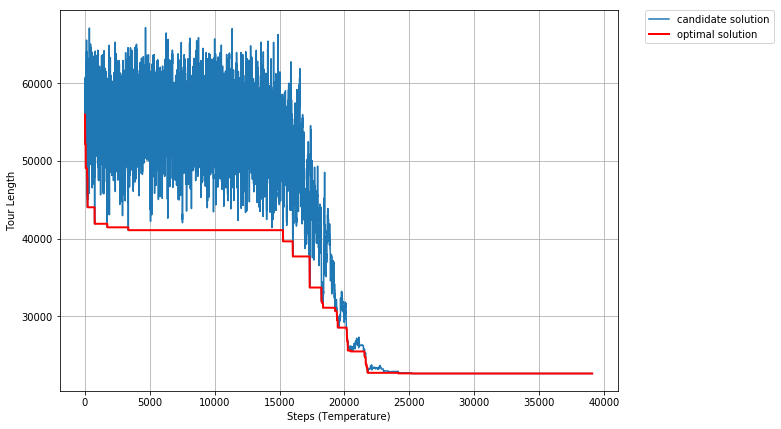

In [17]:
running_lengths = np.array(running_lengths)
optimal_lengths = np.array(optimal_lengths)

plt.figure(figsize = (10, 7))
plt.plot(np.arange(len(running_lengths)), running_lengths, label="candidate solution")
plt.plot(np.arange(len(optimal_lengths)), optimal_lengths, 'r-', linewidth=2, label="optimal solution")

plt.xlabel("Steps (Temperature)")
plt.ylabel("Tour Length")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()

plt.show()

Τέλος, με το επόμενο κελί κώδικα δημιουργούμε μια οπτική αναπαράσταση 
της βέλτιστης διαδρομής.


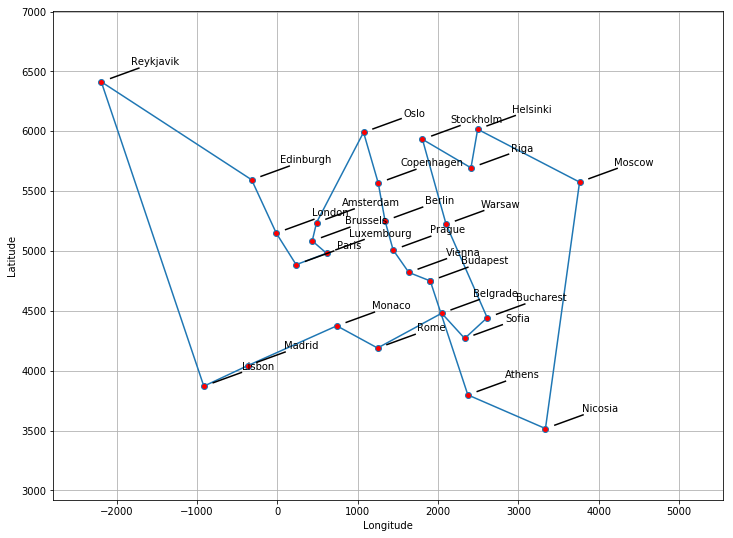

In [18]:
plt.figure(figsize=(12, 9))  # increase image size

# Get Tour Coordinates
coord = np.array([city_coord[city] for city in city_names])
cities = shortest_tour.copy()
cities = np.append(cities, cities[0])
coord = coord[cities,:]  # rearrange

# Scale for better readability
scale_factor = 100
coord = coord * scale_factor

# Plot Tour
plt.plot(coord[:, 1], coord[:,0], 'o-', mfc='r')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()

# Manage spacing
spacing = np.fabs(min(coord[:,1]) - max(coord[:,1])) * .1
plt.xlim(min(coord[:,1]) - spacing, max(coord[:,1]) + spacing * 3)
plt.ylim(min(coord[:,0]) - spacing, max(coord[:,0]) + spacing)

# Add labels - remove for more clear picture
if len(cities)<=30:
    for i, city in enumerate(cities[:-1]):
        plt.text(coord[i,1], coord[i,0],
                 '%s' % city_names[city],
                 withdash = True,
                 dashdirection = 1,
                 dashlength = 30,
                 rotation = 0,
                 dashrotation = 20,
                 dashpush = 10)
plt.show()

## Παραδοτέο

Σε συνέχεια του προηγούμενο notebook:

Α) Δοκιμάστε να βελτιώσετε την λύση πειράζοντας της παραμέτρους του κώδικα.

B) Τρέξτε τον κώδικα του πλανόδιου πωλητή για 35 πόλεις τις Ευρώπης.
(Τα δεδομένα είναι σε αυτή τη διεύθυνσης

`http://math.ntua.gr/~loulakis/info/python_codes_files/europe.csv`

Αλλάχτε το `url` στο αντίστοιχο κελί κώδικα απλά.

Και για τα 2 υποερωτήματα, πλοτάρετε τα 2 γραφήματα (εξέλιξη της τρέχουσας βέλτιστης λύσης και προτεινόμενη διαδρομή) όπως σε αυτό το notebook.

Γ) Σε ένα κελί κειμένου, απαντήστε στις παρακάτω ερωτήσεις:

1. Πόσα είναι τα δυνατά μονοπάτια που περνούν από όλες τις 35 πόλεις μία μόνο φορά; 

2. Αν σε έναν υπολογιστή ο χρόνος που απαιτείται για τον υπολογισμό του συνολικού μήκους ενός τέτοιου μονοπατιού ήταν 1μsec, πόσο χρόνο θα χρειαζόμασταν για να βρούμε το βέλτιστο μονοπάτι με έναν εξαντλητικό αλγόριθμο (brute force) που θα υπολόγιζε τη συνολική απόσταση που θα διανύσει ο πλανόδιος πωλητής κατά μήκος κάθε μονοπατιού και θα επέστρεφε το μονοπάτι με την ελάχιστη συνολική απόσταση;